## Libraries

In [1]:
import os

In [2]:
run = 'local' #local or cloud
os.environ["APP_ENV"] = run

In [3]:
import sys
sys.path.append('..')

In [6]:
from src.grass_functions import*
from src.process_inputs import*
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

# Parameters

In [7]:
#set project variables
Project_Area = 'kc_debug'
GRASS_GIS_Projection = projection = '5070' #set to None if you want to use the DEM's original projection
res = '10m'

## Set variables analysis
data_scale = 'HUC12' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '102701040607' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = None #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
buffer = 2000
auto_delete = False

In [8]:
if data_scale.find('HUC') >= 0:
    huc_level = re.findall("[0-9]+",data_scale)[0]
    if huc_level == str(len(select_data)):
        huc_digys = huc_level
    else:
        huc_digys = huc_level
        select_data = select_data[:int(huc_digys)]

In [9]:
## Paths:
parent_dir = pl.Path(os.getcwd()).parent/'data'
current_dir = pl.Path(os.getcwd())
outputs_dir =parent_dir/'Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Vectors'/Project_Area
raster_dir = parent_dir/'Rasters'/Project_Area
huc_path = vector_dir/'{}_aoi.geojson'.format(Project_Area)
git_data_repo = current_dir/'data_repository'
if input_shp_name:
    input_shp = vector_dir/input_shp_name
directory = outputs_dir

### Get area of interest

In [10]:
#read from to vector path from notebook 1
huc_path = vector_dir/'{0}_{1}_aoi.geojson'.format(Project_Area,select_data)
aoi = gpd.read_file(str(huc_path),driver="GeoJSON")

[2025-08-13 19:03:01,156] [WARNING] [geodataframe] : Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


### Start new grass session

In [11]:
#set projection if none exists
if not GRASS_GIS_Projection:
    dem_vrt = raster_dir/'dem'/'dem_{}.vrt'.format(select_data)
    GRASS_GIS_Projection = projection = get_raster_epsg(dem_vrt)
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'

In [12]:
raster_dir

PosixPath('/home/data/Rasters/kc_debug')

In [13]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)
#initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

{'GISDBASE': "'/home/grassdata';", 'LOCATION_NAME': "'kc_debug_5070';", 'MAPSET': "'PERMANENT';"}
Database Mapset Exists
None
{'GISDBASE': '/home/grassdata', 'LOCATION_NAME': 'kc_debug_5070', 'MAPSET': 'PERMANENT'}


Current GRASS GIS 7 environment:


#### Review existing files

In [14]:
gs.run_command('g.remove',type='raster',name='None',flags='f')

0

In [15]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:

Available raster maps:


In [16]:
basin_list = aoi[data_scale.lower()].to_list()
basins = 'aoi'
gs.run_command('v.import', input= huc_path,  output= basins)
print('added aoi to grass')

Check if OGR layer <kc_debug_102701040607_aoi> contains polygons...
   0 100
Creating attribute table for layer <kc_debug_102701040607_aoi>...
Importing 1 features (OGR layer <kc_debug_102701040607_aoi>)...
   0 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
-----------------------------------------------------
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
-----------------------------------------------------
Removing duplicates...
 100
-----------------------------------------------------
Breaking boundaries...
   0 100
-----------------------------------------------------
Removing duplicates...
 100
-----------------------------------------------------
Cleaning boundaries at nodes...
 100
-----------------------------------------------------
Merging boundaries...
 100
------------------

added aoi to grass


Input </home/data/Vectors/kc_debug/kc_debug_102701040607_aoi.geojson>
successfully imported without reprojection


d.vect complete.


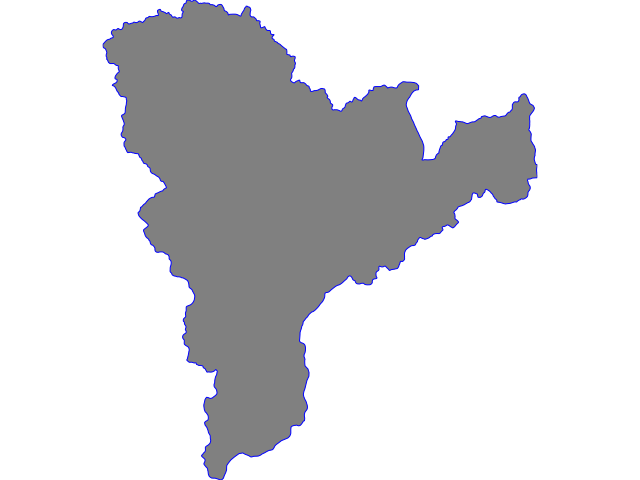

In [17]:
##print basins in grass @ Regional scale to confirm data and extent
gs.parse_command('g.region',vector = basins)
gs.run_command('d.erase')

#gs.run_command('d.vect', map='tmp_bsn_buffer',color='red',fill_color='gray')
gs.run_command('d.vect', map= basins,color='blue',fill_color='gray')

Image(filename="map.png")

### Get Raster data

#### Must first run DEM Download Notebook at
[DEM Download](DEM_download.ipynb#section_id1)
<a id='section_id1'></a>

#### Import raster tiles in correct projection and units

In [18]:
##combine and convert all raster tiles output from DEM Download Notebook into UTM Zone feet vert unit
dems = dem_tiles_to_gis(gs,raster_dir/'dem',Project_Area,'feet',delete_raw=True,force=False) #if patch = True returns joined DEM 

adding raster USGS_13_n40w095_20240228_2024_02_29


Importing raster map <USGS_13_n40w095_20240228_2024_02_29>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
[2025-08-13 19:05:34,002] [INFO] [grass_functions] : converting vertical units to feet. Raw DEM * 3.280839895013123
Rename raster <new_rast> to <USGS_13_n40w095_20240228_2024_02_29>


In [19]:
b_dems = basin_dems(dems,basins, basin_list,data_scale,raster_dir,buffer = (buffer), remove_tiles = True,fill_nulls = False,export_tiff = True) #can add option to ignore nulls, buffer distance is in map units

Extracting features...
  50 100
Building topology for vector map <tmp_bsn@PERMANENT>...
Registering primitives...
Building areas...
   0 100
Attaching islands...
   0 100
Attaching centroids...
   0 100
Writing attributes...
Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <tmp_bsn_buffer@PERMANENT>...
Registering primitives...
Snapping boundaries...
Reading features...
Snap vertices Pass 1: select points
   0 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0 100
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
Removing duplicates...
 100
Breaking boundaries...
   0 100
Removing duplicates...
 100
Cleaning boundaries at nodes
 100
Building topology for vector map <tmp_bsn_buffer@PERMANENT>...
Building areas..

Patching together rasters for 102701040607


Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF fo

created dem_102701040607.tif


Removing raster <USGS_13_n40w095_20240228_2024_02_29>
Raster MASK removed


In [20]:
gs.run_command('v.db.dropcolumn',map= basins, column='MetaSourceID,SourceDataDesc,SourceOriginator,SourceFeatureID,Shape_Length,noncontributingareaacres,noncontributingareasqkm')
gs.run_command('v.db.dropcolumn',map= basins, column='MetaSourceID,SourceDataDesc,SourceOriginator,SourceFeatureID,Shape_Length'.lower())
gs.run_command('v.out.ogr', input=  basins,type = 'area',output = vector_dir/'{}.shp'.format(select_data), format = 'ESRI_Shapefile',flags='e')

Warning 1: Field tnmid of width 1000 truncated to 254.
Warning 6: Field loaddate create as date field, though DateTime requested.
Warning 1: Field gnis_id of width 1000 truncated to 254.
Warning 1: Field name of width 1000 truncated to 254.
Warning 1: Field states of width 1000 truncated to 254.
Warning 1: Field huc12 of width 1000 truncated to 254.
Warning 1: Field hutype of width 1000 truncated to 254.
Warning 1: Field humod of width 1000 truncated to 254.
Warning 1: Field tohuc of width 1000 truncated to 254.
Warning 1: Field vpuid of width 1000 truncated to 254.
Exporting 1 area (may take some time)...
 100
Warning 1: Value 23001000150228 of field nhdplusid of feature 0 not successfully written. Possibly due to too larger number with respect to field width
v.out.ogr complete. 1 feature (Polygon type) written to <aoi>
(ESRI_Shapefile format).


0

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.


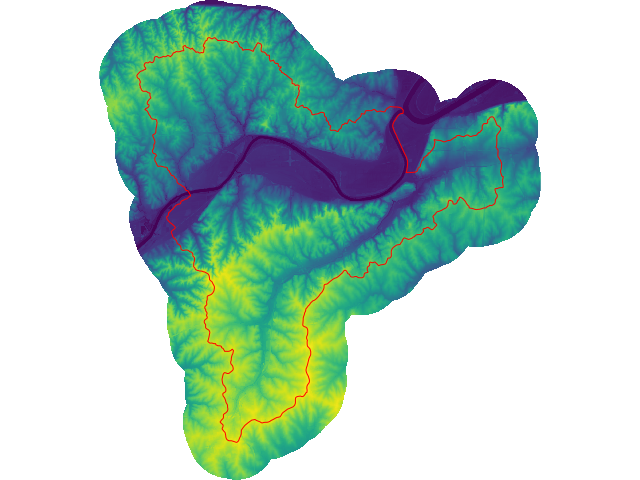

In [21]:
##print basins in grass @ Regional scale to confirm data and extent
gs.parse_command('g.region',vector = 'tmp_bsn_buffer', align = b_dems[0])
gs.run_command('d.erase')
gs.run_command('d.rast', map= b_dems[0])
gs.run_command('d.vect', map= basins,color='red',fill_color='None')
Image(filename="map.png")

In [20]:
import shutil
if auto_delete is True:
    #remove all files to save space
    remove_grass_data(grass_maps,'all','raster') #update 'None' with map name or type (i.e. 'raster' or 'vector')
    remove_grass_data(grass_maps,'all','vector') #update 'None' with map name or type (i.e. 'raster' or 'vector')
    #delete temp files
    shutil.rmtree(pl.Path('/home')/'grassdata'/Location/Mapset/'.tmp')
    os.makedirs(pl.Path('/home')/'grassdata'/Location/Mapset/'.tmp')

## Align to specific grid (optional)

## END